In [1]:
import numpy as np

import networkx as nx
from random import random
from numpy import arctan2, pi

import scipy.stats as sts
from scipy.stats import norm
from scipy import signal

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
from PIL import Image, ImageDraw, ImageFont

In [2]:
def unnormalized_distribution(x, y):
    
    measurements = [2.349080, -1.276010, -2.081865]
    buoys = [[-2.5, 2], [2, -5], [-3, -4]]
    sigma = 10/180*pi
    posterior = 1
    for i in range(3):
        bearing = arctan2(buoys[i][1] - y, buoys[i][0] - x)
        difference = (bearing - measurements[i] + pi) % (2 * pi) - pi
        posterior *= norm.pdf(difference, loc=0, scale=sigma)
    return posterior

In [23]:
def custom_mh(n = 100000, step = 20, burn_in = 10):
    """
    Performs Metropolis-Hastings sampling over a poserior
    """
    samples = np.zeros((2,n//step), dtype = np.float16)
    rejections = np.zeros(n)

    # Initializations, which will be discarded
    curr_x = 1
    curr_y = 1

    eps_x = 1
    eps_y = 2

    for i in range(n):
        proposal_x = norm(curr_x, eps_x).rvs()
        proposal_y = norm(curr_y, eps_y).rvs()

        proposal = unnormalized_distribution(proposal_x,proposal_y)
        current = unnormalized_distribution(curr_x, curr_y)
        ratio = proposal/current

        accept = random() < min(1,ratio)

        if accept:
            curr_x = proposal_x
            curr_y = proposal_y
        else:
            rejections[i] = 1
        
        if i % step == 0 and i > burn_in:
            samples[:, i//step] = curr_x, curr_y

    return samples

chain1,chain2,chain3 = custom_mh(10000), custom_mh(10000), custom_mh(10000)

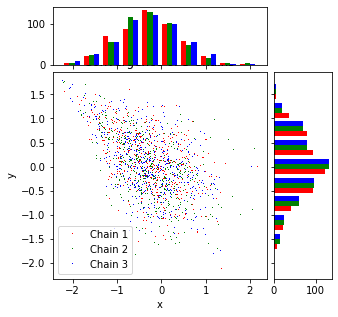

In [25]:
fig, ax = plt.subplots(figsize=(5, 5), sharex = False)

# the scatter plot:
ax.plot(
    chain1[0,:],
    chain1[1,:], 
    ',',
    alpha = 1,
    c = 'red',
    label = 'Chain 1')

ax.plot(
    chain2[0,:],
    chain2[1,:], 
    ',',
    alpha = 1,
    c = 'green',
    label = 'Chain 2')

ax.plot(
    chain3[0,:],
    chain3[1,:], 
    ',',
    alpha = 1,
    c = 'blue',
    label = 'Chain 3')


# create new axes on the right and on the top of the current axes
divider = make_axes_locatable(ax)
# below height and pad are in inches
ax_histx = divider.append_axes("top", 0.8, pad=0.1, sharex=ax)
ax_histy = divider.append_axes("right", 0.8, pad=0.1, sharey=ax)

ax_histx.xaxis.set_tick_params(labelbottom=False)
ax_histy.yaxis.set_tick_params(labelleft=False)

ax_histx.hist([chain1[0,:], chain2[0,:], chain3[0,:]], bins=10, color = ['red','green','blue'])
ax_histy.hist([chain1[1,:],chain2[1,:],chain2[1,:]], bins=10, orientation='horizontal', color = ['red','green','blue'])

ax.set_ylabel("y")
ax.set_xlabel("x")
ax.set_title("Convergence of 3 Chains")
ax.legend()

# Plot autocorrelation
plt.show()